In [1]:
#Checking if GPU is running or not

!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# !pip install datasets transformers[sentencepiece] sacrebleu -q

In [3]:
import os
import sys
import transformers
import tensorflow as tf
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from datasets import Dataset,DatasetDict
from transformers import AutoTokenizer
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import numpy as np
import matplotlib.pyplot as plt

In [4]:
model_checkpoint = "tf_model"

# The Dataset

In [5]:
# # raw_datasets = load_dataset("heb-een.txt")
# custom_dataset = "he-en.txt"
# raw_datasets = load_dataset("text", data_files=custom_dataset)
# raw_datasets["train"][:100]
# Load the custom dataset from the provided text file
custom_dataset = "AncientImages.txt"
with open(custom_dataset, "r", encoding="utf-8") as file:
    lines = file.readlines()

dataset_dict = {"hebrew": [], "english": []}

# Process each line in the dataset file and populate the dictionary
for line in lines:
    # Check if the line contains a tab character
    if "\t" in line:
        hebrew, english = line.strip().split("\t")
        dataset_dict["hebrew"].append(hebrew)
        dataset_dict["english"].append(english)


# Convert the dictionary to a Hugging Face dataset

custom_hf_dataset = Dataset.from_dict(dataset_dict)

# if you want to Combine the custom dataset with the IITB dataset
combined_dataset = DatasetDict({
    "train": Dataset.from_dict({
        "hebrew": custom_hf_dataset["hebrew"] ,
        "english": custom_hf_dataset["english"]
    })
})

# Print the first 100 examples from the combined dataset
print(combined_dataset["train"])


Dataset({
    features: ['hebrew', 'english'],
    num_rows: 231
})


In [6]:
combined_dataset['train'][0]

{'hebrew': 'התמונה המוקרנת על הרישתית מועברת דרך אין ספור יחידות רגישות לאור — קולטי הראיה, המכונים קָנִים וּמְדוֹכִים. הקליטה של פרטים וצבע מעוּלָה ביותר באותו חלק של הרישתית הידוע ככתם הצהוב. בשטח זה אין קנים כלל והמְדוֹכִים ערוכים בו בצפיפות. לכל מָדוֹר קשר עֲצַבִּי משלו ובעובדה זו ערובה לבהירות הגבוהה של הראיה באיזור זה. בחלקים ההיק- ',
 'english': ' The image projected onto the retina is transmitted through innumerable light-sensitive units — the photoreceptors, known as canines and oppressors. The absorption of detail and color is most clouded in the same part of the retina known as the yellow spot. In this territory there are no nests at all and the thickets are densely laid out in it. Each model has its own neural connection and in this fact guarantees the high clarity of vision in this area. In parts of the hick-'}

#Preprocessing the data

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
combined_dataset['train'][0]

{'hebrew': 'התמונה המוקרנת על הרישתית מועברת דרך אין ספור יחידות רגישות לאור — קולטי הראיה, המכונים קָנִים וּמְדוֹכִים. הקליטה של פרטים וצבע מעוּלָה ביותר באותו חלק של הרישתית הידוע ככתם הצהוב. בשטח זה אין קנים כלל והמְדוֹכִים ערוכים בו בצפיפות. לכל מָדוֹר קשר עֲצַבִּי משלו ובעובדה זו ערובה לבהירות הגבוהה של הראיה באיזור זה. בחלקים ההיק- ',
 'english': ' The image projected onto the retina is transmitted through innumerable light-sensitive units — the photoreceptors, known as canines and oppressors. The absorption of detail and color is most clouded in the same part of the retina known as the yellow spot. In this territory there are no nests at all and the thickets are densely laid out in it. Each model has its own neural connection and in this fact guarantees the high clarity of vision in this area. In parts of the hick-'}

In [9]:
tokenizer("אאודי‎")

{'input_ids': [44, 61785, 61785, 53884, 61877, 50781, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [10]:
tokenizer(["𐤁", "אאודי"])

{'input_ids': [[44, 1, 0], [44, 61785, 61785, 53884, 61877, 50781, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

In [11]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["𐤀"]))

{'input_ids': [[44, 1, 0]], 'attention_mask': [[1, 1, 1]]}


C:\Users\PCS\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:3864: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


# Data Labeling

In [12]:
max_input_length = 256
max_target_length = 256

source_lang = "hebrew"
target_lang = "english"

def preprocess_function(examples):
    inputs = examples[source_lang]
    targets = examples[target_lang]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Preprocess the combined dataset
preprocessed_dataset = combined_dataset["train"].map(preprocess_function)

# Print the first 100 examples from the preprocessed dataset
print(preprocessed_dataset[:10])

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

{'hebrew': ['התמונה המוקרנת על הרישתית מועברת דרך אין ספור יחידות רגישות לאור — קולטי הראיה, המכונים קָנִים וּמְדוֹכִים. הקליטה של פרטים וצבע מעוּלָה ביותר באותו חלק של הרישתית הידוע ככתם הצהוב. בשטח זה אין קנים כלל והמְדוֹכִים ערוכים בו בצפיפות. לכל מָדוֹר קשר עֲצַבִּי משלו ובעובדה זו ערובה לבהירות הגבוהה של הראיה באיזור זה. בחלקים ההיק- ', 'רחוב הפטריארכיה הארמנית ', 'ז דברי למטה דן על פי יהוה : לאמר : הוצא או ', 'ז ', 'דברי ', 'למטה ', 'דן ', 'על ', 'פי ', 'יהוה '], 'english': [' The image projected onto the retina is transmitted through innumerable light-sensitive units — the photoreceptors, known as canines and oppressors. The absorption of detail and color is most clouded in the same part of the retina known as the yellow spot. In this territory there are no nests at all and the thickets are densely laid out in it. Each model has its own neural connection and in this fact guarantees the high clarity of vision in this area. In parts of the hick-', ' Armenian Patriarchate Street', 

In [13]:
preprocess_function(preprocessed_dataset[:2])

{'input_ids': [[44, 41351, 1, 53884, 61734, 41351, 44, 41351, 1, 53884, 61880, 1, 61734, 1, 44, 1, 61879, 44, 41351, 1, 50781, 61735, 1, 50781, 1, 44, 1, 53884, 1, 44, 61877, 1, 44, 61785, 50781, 1, 44, 1, 61767, 53884, 1, 44, 50781, 1, 50781, 61877, 53884, 1, 44, 1, 50781, 61735, 53884, 1, 44, 61879, 61785, 53884, 1, 64, 44, 61880, 53884, 61879, 61878, 50781, 44, 41351, 1, 61785, 50781, 41351, 2, 44, 41351, 1, 53884, 61734, 50781, 1, 44, 61880, 61876, 61734, 1, 50781, 1, 44, 53884, 1, 61823, 61877, 53884, 61784, 1, 50781, 1, 3, 44, 41351, 61880, 61879, 50781, 61878, 41351, 44, 61735, 61879, 44, 61767, 1, 61878, 50781, 1, 44, 53884, 1, 44, 1, 53884, 1, 61879, 61876, 41351, 44, 1, 50781, 53884, 1, 44, 1, 61785, 53884, 1, 53884, 44, 1, 61879, 61880, 44, 61735, 61879, 44, 41351, 1, 50781, 61735, 1, 50781, 1, 44, 41351, 50781, 61877, 53884, 1, 44, 1, 44, 41351, 1, 41351, 53884, 1, 3, 44, 1, 61735, 61878, 1, 44, 1, 41351, 44, 61785, 50781, 1, 44, 61880, 61734, 50781, 1, 44, 1, 61879, 61879,

In [14]:
tokenized_datasets = preprocessed_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

In [15]:
model = TFAutoModelForSeq2SeqLM.from_pretrained("tf_model/")

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at tf_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


In [16]:
batch_size = 16
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 2

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [18]:
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128)

In [19]:
train_dataset = model.prepare_tf_dataset(
    tokenized_datasets,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)


In [20]:
validation_dataset = model.prepare_tf_dataset(
    tokenized_datasets,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

In [21]:
generation_dataset = model.prepare_tf_dataset(
    tokenized_datasets,
    batch_size=8,
    shuffle=False,
    collate_fn=generation_data_collator,
)

In [22]:
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer, metrics=["accuracy"])

In [23]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=20)

Epoch 1/20
14/14 [==============================] - 440s 25s/step - loss: 0.0611 - accuracy: 0.1228 - val_loss: 0.0637 - val_accuracy: 0.1532
Epoch 2/20
14/14 [==============================] - 331s 24s/step - loss: 0.0828 - accuracy: 0.1443 - val_loss: 0.0594 - val_accuracy: 0.1533
Epoch 3/20
14/14 [==============================] - 293s 20s/step - loss: 0.0504 - accuracy: 0.1564 - val_loss: 0.0419 - val_accuracy: 0.1545
Epoch 4/20
14/14 [==============================] - 374s 24s/step - loss: 0.0569 - accuracy: 0.1260 - val_loss: 0.0394 - val_accuracy: 0.1550
Epoch 5/20
14/14 [==============================] - 379s 28s/step - loss: 0.0524 - accuracy: 0.1189 - val_loss: 0.0380 - val_accuracy: 0.1550
Epoch 6/20
14/14 [==============================] - 378s 28s/step - loss: 0.0510 - accuracy: 0.1213 - val_loss: 0.0407 - val_accuracy: 0.1547
Epoch 7/20
14/14 [==============================] - 314s 23s/step - loss: 0.0486 - accuracy: 0.1606 - val_loss: 0.0386 - val_accuracy: 0.1550
Epoch 

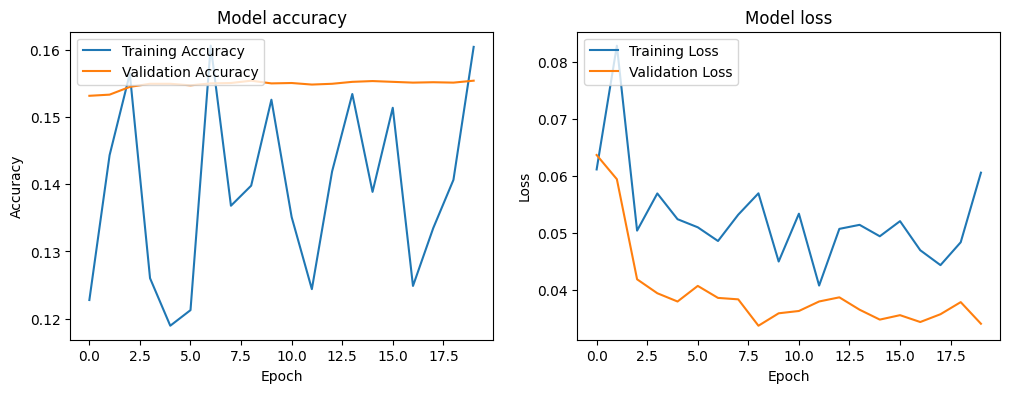

In [24]:
import matplotlib.pyplot as plt

# Specify the figure size
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


# Model Testing

In [25]:
model.save_pretrained("tf_model/")
tokenizer.save_pretrained("tf_model/")

('tf_model/tokenizer_config.json',
 'tf_model/special_tokens_map.json',
 'tf_model/vocab.json',
 'tf_model/added_tokens.json')

In [26]:
# import matplotlib.pyplot as plt
# from datasets import load_metric

# sacrebleu = load_metric("sacrebleu")

# # Initialize a list to store generated translations
# generated_translations = []

# # Loop over the examples in the dataset
# for i, example in enumerate(combined_dataset["train"]["hebrew"][0:94]):
#     # Take input text from the dataset
#     input_text = example

#     # Tokenize the input text
#     tokenized = tokenizer([input_text], return_tensors='np')

#     # Generate the text using the model
#     out = model.generate(**tokenized, max_length= 128 , num_beams=1, no_repeat_ngram_size=2)

#     # Decode the generated output
#     with tokenizer.as_target_tokenizer():
#         generated_text = tokenizer.decode(out[0], skip_special_tokens=True)

#     # Append the generated translation to the list
#     generated_translations.append(generated_text)

#     # Print input text with the current value of i
#     print(f"{i + 1}. Input Text:")
#     print(input_text)

#     # Print generated text with the current value of i
#     print(f"{i + 1}. Generated Text:")
#     print(generated_text)

#     # Create a bar chart to visualize the text generation (uncomment if needed)
#     # step_labels = [f"Step {i+1}" for i in range(len(generated_text))]
#     # step_lengths = [len(tokenizer.decode(out[0][:i+1], skip_special_tokens=True)) for i in range(len(generated_text))]
#     # plt.figure(figsize=(12, 4))
#     # plt.bar(step_labels, step_lengths)
#     # plt.xlabel("Generation Steps")
#     # plt.ylabel("Text Length")
#     # plt.title("Text Generation Process")
#     # plt.xticks(rotation=45)
#     # plt.tight_layout()
#     # plt.show()


In [27]:
# Take top 10 rows for human-generated reference translation
from datasets import load_metric

sacrebleu = load_metric("sacrebleu")
refs = combined_dataset["train"]["english"][0:94]

# Remove leading spaces from reference translations
refs = [[ref.strip()] for ref in refs]

# Modify generated_translations to have each sentence in its own list
hypothesis = [[sentence] for sentence in generated_translations[:94]]

print("Reference Translations:-")
print(refs)
print("Model Translation:-")
print(hypothesis)

# Calculate BLEU score
bleu = sacrebleu.compute(predictions=hypothesis, references=refs)
print(f"BLEU score: {bleu['score']}")

# Calculate character frequency (chr-F) score
def calculate_chr_f(hypothesis, reference):
    generated_chars = [char for word in hypothesis for char in word]
    reference_chars = [char for word in reference for char in word]

    if not generated_chars or not reference_chars:
        return 0.0  # Return 0 if either list is empty to avoid division by zero

    overlap = len(set(generated_chars).intersection(reference_chars))
    precision = overlap / len(generated_chars)
    recall = overlap / len(reference_chars)

    if precision + recall == 0:
        return 0.0  # Return 0 if the denominator is zero to avoid division by zero

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


# Initialize a list to store chr-F scores
chr_f_scores = [calculate_chr_f(hypothesis, reference) for hypothesis, reference in zip(generated_translations, refs)]
average_chr_f = sum(chr_f_scores) / len(chr_f_scores)

# Print individual chr-F scores
for i, score in enumerate(chr_f_scores):
    print(f"chr-F score {i+1}: {score:.3f}")

print(f"Average chr-F score: {average_chr_f:.3f}")

sacrebleu.compute(predictions=hypothesis, references=refs)


C:\Users\PCS\AppData\Local\Temp\ipykernel_7868\3291091202.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  sacrebleu = load_metric("sacrebleu")


NameError: name 'generated_translations' is not defined

In [ ]:
model.summary();

In [ ]:
import matplotlib.pyplot as plt

# Replace these with actual BLEU scores
bleu_scores = [ 14.6, 3.7, 0.37, 14.85]  # Sample BLEU scores for different test sets
sentences = [3, 100, 1000, 10000]  # Corresponding epochs

plt.plot(sentences, bleu_scores, marker='o', linestyle='-')
plt.title('BLEU Scores Over No of sentences')
plt.xlabel('No of Sentences')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()


chr_freq = [0.75, 0.52, 0.45, 0.73]  # Corresponding epochs

plt.plot(chr_freq, bleu_scores, marker='o', linestyle='-')
plt.title('BLEU Scores Over character_frequency')
plt.xlabel('Character Frequency')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
epochs = [1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52]  # List of epochs
train_loss = [1.84,1.60,1.50,1.42,1.28,1.17,1.09,1.01,0.94,0.88,0.82,0.77,1.05,0.94,0.86,0.80,0.74,0.69,0.65,0.60,0.57,0.53,0.50,0.47,0.44,0.41,0.39,0.37,0.35,0.29,0.27,0.26,0.24,0.72,0.66,0.63,0.60,0.57,0.54,0.52,0.50,0.48,0.46,0.42,0.40,0.39,0.38,0.35,0.34,0.29,0.28,0.26]  # Training loss for each epoch
train_accuracy = [0.22,0.24,0.25,0.33,0.34,0.35,0.36,0.37,0.38,0.38,0.39,0.40,0.38,0.39,0.40,0.40,0.41,0.42,0.42,0.43,0.43,0.44,0.44,0.44,0.45,0.45,0.45,0.46,0.46,0.47,0.47,0.47,0.47,0.43,0.44,0.44,0.45,0.45,0.46,0.46,0.46,0.46,0.47,0.47,0.47,0.48,0.48,0.48,0.48,0.49,0.49,0.50]  # Training accuracy for each epoch
val_loss = [1.56,1.34,1.24,1.13,1.01,0.91,0.83,0.76,0.69,0.63,0.58,0.53,0.83,0.75,0.67,0.61,0.56,0.51,0.47,0.43,0.39,0.36,0.33,0.30,0.28,0.25,0.23,0.21,0.20,0.15,0.14,0.13,0.12,0.52,0.48,0.46,0.43,0.41,0.39,0.37,0.35,0.34,0.32,0.29,0.28,0.27,0.27,0.25,0.24,0.22,0.21,0.20]  # Validation loss for each epoch
val_accuracy = [0.52,0.56,0.58,0.61,0.63,0.65,0.67,0.68,0.69,0.71,0.72,0.73,0.67,0.68,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.76,0.77,0.78,0.78,0.79,0.79,0.80,0.80,0.81,0.81,0.82,0.82,0.72,0.73,0.74,0.74,0.75,0.75,0.76,0.76,0.77,0.77,0.78,0.78,0.78,0.78,0.79,0.79,0.79,0.80,0.80]  # Validation accuracy for each epoch
# Specify the file path
file_path = 'training_data.txt'
epoch_num = 52 
# Open the file in write mode
with open(file_path, 'w') as file:
    # Write the header
    file.write("Epoch\tTraining Loss\tTraining Accuracy\tValidation Loss\t\tValidation Accuracy\n")

    # Write data line by line
    for epoch, (epoch_num, train_l, train_acc, val_l, val_acc) in enumerate(zip(epochs, train_loss, train_accuracy, val_loss, val_accuracy), start=1):
        file.write(f"{epoch_num}\t\t{train_l:.4f}\t\t\t{train_acc:.4f}\t\t\t\t{val_l:.4f}\t\t\t\t{val_acc:.4f}\n")

# Print a message indicating successful file creation
print(f"Data has been saved to {file_path}")

# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accuracy, marker='o', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Data
test_sets = ['newsdev2014.eng.hin', 'newstest2014-hien.eng.hin', 'Tatoeba-test.eng.hin', 'AncientLanguageTranslation2023.heb-eng']
bleu_scores = [7.0, 9.9, 16.1, 14.85]
chr_f_scores = [0.297, 0.323, 0.447, 0.730]
bp_scores = [1.000, 0.938, 1.000, 1.000]

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 6))  # Increase the figure width

# Plot BLEU scores with brown color
color = 'tab:red'  # Use brown color
ax1.set_xlabel('Test Sets')
ax1.set_ylabel('BLEU', color=color)
ax1.bar(test_sets, bleu_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for chr-F and BP scores
ax2 = ax1.twinx()
color_chr_f = 'tab:blue'
color_bp = 'tab:green'
ax2.set_ylabel('chr-F / BP', color=color_chr_f)
ax2.plot(test_sets, chr_f_scores, color=color_chr_f, marker='o', label='chr-F')
ax2.plot(test_sets, bp_scores, color=color_bp, marker='o', label='BP')
ax2.tick_params(axis='y', labelcolor=color_chr_f)

# Highlight AncientLanguageTranslation2023.heb-eng with brown color
highlight_test_set = 'AncientLanguageTranslation2023.heb-eng'
highlight_index = test_sets.index(highlight_test_set)
ax1.get_children()[highlight_index].set_facecolor('saddlebrown')  # Use darkred to highlight

# Show legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Title and display
plt.title('Comparison of Translation Metrics for Different Test Sets')
plt.show()
plt.savefig('comparison_graphs.png')

In [ ]:
import matplotlib.pyplot as plt

# Data
bleu_scores = [14.6, 3.7, 0.37, 6.22, 14.85]
sentences = [3, 100, 1000,13270, 10000]
chr_frequency = [0.75, 0.52, 0.45, 0.56, 0.73]
data_points_sentences = ['3 sentences', '100 sentences', '1000 sentences',  '13270 sentences', '10000 sentences']
data_points_chr_frequency = ['0.75 chr-F', '0.52 chr-F', '0.45 chr-F', '0.56 chr-F', '0.73 chr-F']

# Plotting BLEU Scores versus Sentences
fig, ax1 = plt.subplots(figsize=(10, 6))

color_bleu = 'tab:red'
ax1.set_xlabel('Data Points')
ax1.set_ylabel('BLEU Scores', color=color_bleu)
ax1.bar(data_points_sentences, bleu_scores, color=color_bleu)
ax1.tick_params(axis='y', labelcolor=color_bleu)

ax2 = ax1.twinx()
color_sentence = 'tab:blue'
ax2.set_ylabel('Sentences', color=color_sentence)
ax2.plot(data_points_sentences, sentences, color=color_sentence, marker='o', label='Sentences')
ax2.tick_params(axis='y', labelcolor=color_sentence)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('BLEU Scores versus Sentences')
plt.show()

# Plotting BLEU Scores versus Character Frequency
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Data Points')
ax1.set_ylabel('BLEU Scores', color=color_bleu)
ax1.bar(data_points_chr_frequency, bleu_scores, color=color_bleu)
ax1.tick_params(axis='y', labelcolor=color_bleu)

ax2 = ax1.twinx()
color_chr_frequency = 'tab:green'
ax2.set_ylabel('Character Frequency', color=color_chr_frequency)
ax2.plot(data_points_chr_frequency, chr_frequency, color=color_chr_frequency, marker='o', label='Character Frequency')
ax2.tick_params(axis='y', labelcolor=color_chr_frequency)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('BLEU Scores versus Character Frequency')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
algorithms = ['LSTM', 'Transformer']
num_sentences = [10000, 180000]
accuracy = [0.9988, 0.46]
val_acc = [0.8133, 0.80]
loss = [0.0047, 0.37]
val_loss = [1.7004, 0.21]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of LSTM and Transformer', fontsize=16)

# Bar chart for Number of Sentences
axs[0, 0].bar(algorithms, num_sentences, color=['skyblue', 'lightcoral'])
axs[0, 0].set_ylabel('Number of Sentences')

# Grouped bar chart for Accuracy and Val_acc
bar_width = 0.35
index = np.arange(len(algorithms))
axs[0, 1].bar(index - bar_width/2, accuracy, bar_width, label='Accuracy', color='skyblue')
axs[0, 1].bar(index + bar_width/2, val_acc, bar_width, label='Val_acc', color='lightcoral')
axs[0, 1].set_xticks(index)
axs[0, 1].set_xticklabels(algorithms)
axs[0, 1].legend()
axs[0, 1].set_ylabel('Accuracy / Val_acc')

# Grouped bar chart for Loss and Val_loss
axs[1, 0].bar(index - bar_width/2, loss, bar_width, label='Loss', color='skyblue')
axs[1, 0].bar(index + bar_width/2, val_loss, bar_width, label='Val_loss', color='lightcoral')
axs[1, 0].set_xticks(index)
axs[1, 0].set_xticklabels(algorithms)
axs[1, 0].legend()
axs[1, 0].set_ylabel('Loss / Val_loss')

# Remove empty subplot
fig.delaxes(axs[1, 1])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
plt.savefig('comparison_graphs.png')

# Show the figure
plt.show()


In [ ]:
from datasets import load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import matplotlib.pyplot as plt

sacrebleu = load_metric("sacrebleu")
model_checkpoint = "tf_model"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("tf_model/")

# Initialize a list to store generated translations
generated_translations = []

# Continue the loop until the user presses 'c'
while True:
    # Take input text from the user
    input_text = input("Enter input text (or 'c' to terminate): ")

    # Check if the user wants to terminate the loop
    if input_text.lower() == 'c':
        print("Terminating the loop.")
        break

    # Preprocess input: Skip very short inputs
    if len(input_text) < 1:
        print("Input text is too short. Skipping.")
        continue

    # Tokenize the input text
    tokenized = tokenizer([input_text], return_tensors='np')

    # Generate the text using the model with max_length set dynamically
    out = model.generate(**tokenized, max_length= len(input_text)+2, num_beams=1, no_repeat_ngram_size=2)

    # Decode the generated output
    with tokenizer.as_target_tokenizer():
        generated_text = tokenizer.decode(out[0], skip_special_tokens=True)


    print("\nInput Text:")
    print(input_text)
    # Print the final generated text
    print("\nGenerated Text:")
    print(generated_text)
    print("\n---\n")


In [ ]:
from datasets import load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
import re

sacrebleu = load_metric("sacrebleu")
model_checkpoint = "tf_model"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained("tf_model/")

# Continue the loop until the user presses 'c'
while True:
    # Take input text from the user
    input_text = input("Enter input text (or 'c' to terminate): ")

    # Check if the user wants to terminate the loop
    if input_text.lower() == 'c':
        print("Terminating the loop.")
        break

    # Preprocess input: Skip very short inputs
    if len(input_text) < 1:
        print("Input text is too short. Skipping.")
        continue

    words = re.findall(r'\b\w+\b', input_text)
    
    # Check if any of the characters are English characters or numerals
    if any(char.isascii() or char.isdigit() for char in ''.join(words)):
        # If any of the characters are English characters or numerals, set generated text using word-based logic
        processed_text2 = ""

        for word in words:
            if any(not char.isascii() and not char.isdigit() for char in word):
                # Separate Hebrew, English, and numbers
                hebrew_part = ''.join(char for char in word if not char.isascii() and not char.isdigit())
                english_number_part = ''.join(char for char in word if char.isascii() or char.isdigit())

                # Translate the Hebrew part
                tokenized = tokenizer([hebrew_part], return_tensors='np')
                out = model.generate(**tokenized, max_length=len(hebrew_part) + 2, num_beams=1, no_repeat_ngram_size=2)
                with tokenizer.as_target_tokenizer():
                    generated_word = tokenizer.decode(out[0], skip_special_tokens=True)

                # Combine the translated Hebrew with the English and numbers
                processed_text2 += generated_word + english_number_part + " "
            else:
                processed_text2 += word + " "

        print("\nGenerated Text2:")
        print(processed_text2.strip())  # Remove trailing space
        print("\n---\n")

    else:
        # If none of the characters are English characters or numerals, set generated text using sentence-based logic
        tokenized = tokenizer([input_text], return_tensors='np')
        out = model.generate(**tokenized, max_length=len(input_text) + 2, num_beams=1, no_repeat_ngram_size=2)
        with tokenizer.as_target_tokenizer():
            processed_text1 = tokenizer.decode(out[0], skip_special_tokens=True)
            print("\nInput Text:")
            print(input_text)
            # Print the final generated text
            print("\nGenerated Text1:")
            print(processed_text1.strip())  # Remove trailing space
            print("\n---\n")


In [ ]:
# from googletrans import Translator
# import time

# def translate_hebrew_file(input_file, output_file, error_file):
#     # Create a Translator object with custom service URLs
#     translator = Translator(service_urls=['translate.google.com'])

#     # Read lines from the input file
#     with open(input_file, 'r', encoding='utf-8') as file:
#         lines = file.readlines()

#     # Record start time for execution measurement
#     start_time = time.time()

#     # Open output and error log files for writing
#     with open(output_file, 'w', encoding='utf-8') as output, open(error_file, 'w', encoding='utf-8') as error_log:
#         # Iterate through each line in the input file
#         for line in lines:
#             # Strip leading and trailing whitespaces
#             line = line.strip()

#             # Check if the line is not empty
#             if line:
#                 try:
#                     # Translate from Hebrew to English
#                     translation = translator.translate(line, src='he', dest='en')

#                     # Check if the translation text is not empty
#                     if translation.text:
#                         english_text = translation.text
#                         # Write the original Hebrew and translated English text to the output file
#                         output.write(f"{line} \t {english_text}\n")
#                     else:
#                         # Write the original Hebrew line to the error log if translation text is empty
#                         error_log.write(f"{line}\n")
#                 except Exception as e:
#                     # Write the original Hebrew line to the error log in case of an exception
#                     error_log.write(f"{line}\n")

#     # Record end time for execution measurement
#     end_time = time.time()
#     execution_time = end_time - start_time
#     print(f"Translation completed in {execution_time} seconds.")

# # Example usage
# input_file = "hebrew_file.txt"
# output_file = "translated_file.txt"
# error_file = "translation_errors.txt"

# translate_hebrew_file(input_file, output_file, error_file)


In [ ]:
# !pip install googletrans==4.0.0-rc1

In [ ]:
# # Function to read content from a file and return it as a list of lines
# def read_file(file_path):
#     with open(file_path, 'r', encoding='utf-8') as file:
#         return file.readlines()

# # Function to write content to a file
# def write_file(file_path, content):
#     with open(file_path, 'w', encoding='utf-8') as file:
#         file.writelines(content)

# # File paths
# file1_path = 'file1.txt'
# file2_path = 'file2.txt'
# output_path = 'Pheonecian.txt'

# # Read content from the two files
# file1_content = read_file(file1_path)
# file2_content = read_file(file2_path)

# # Ensure both files have the same number of lines
# min_length = min(len(file1_content), len(file2_content))
# file1_content = file1_content[:min_length]
# file2_content = file2_content[:min_length]

# # Combine content with tab space between them
# combined_content = [f"{file1_line.strip()}\t{file2_line.strip()}\n" for file1_line, file2_line in zip(file1_content, file2_content)]

# # Write the combined content to the output file
# write_file(output_path, combined_content)

# print(f"Combined content has been written to {output_path}")
